# Probability Analysis in Trading

In [15]:
%matplotlib inline

import numpy as np
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import datetime

import sys
sys.path.append('C:\\projects\\finances.git\\finances')

from market.market_data import MarketData
mkt = MarketData()

Loaded crypto currency database from C:\projects\finances.git\finances\market\data_base\crypto_currencies\main_crypto_eur_database.csv


In [16]:
eth_price = mkt.get_crypto_price_data('ETH', start_date=datetime.datetime(2018,1,26))

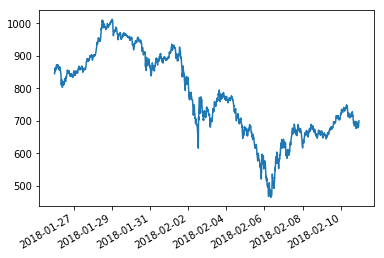

In [17]:
eth_price.plot()

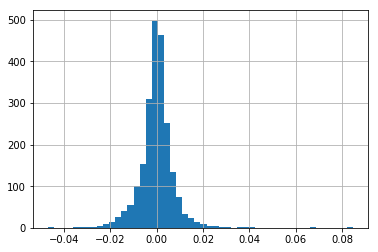

In [18]:
eth_rets = mkt.crypto_returns_data('ETH', time_step='10T', start_date=datetime.datetime(2018,1,26))
eth_rets.hist(bins=50)

# Quest for invariance
Two tests for invariance are necessary. The next function makes those two tests:

In [19]:
def test_invariance(data):
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    # test 1
    N = len(data)
    first_half = data.iloc[:int(N/2)]
    second_half = data.iloc[int(N/2)+1:]
    first_half.hist(bins=50, alpha=0.6, ax=ax[0], normed=True)
    second_half.hist(bins=50, alpha=0.6, ax=ax[0], normed=True)
    ax[0].set_title('Test invariance 1')
    
    # test 2
    ax[1].scatter(data[:-2], data[1:-1])
    ax[1].set_title('Test invariance 2')
    return ax
    

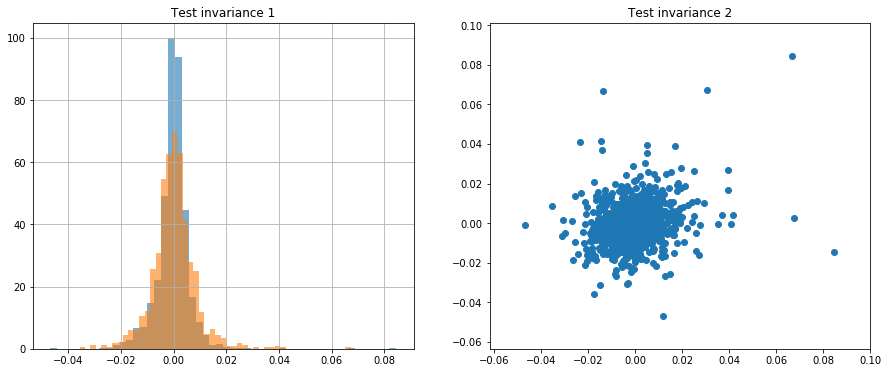

In [20]:
coin = 'ETH'
data = mkt.crypto_returns_data(coin, time_step='10T', start_date=datetime.datetime(2018,1,26)).dropna()
ax = test_invariance(data)

(2.5565257114898872, -3.8257761133069166e-05, 0.0042494701826348499)


Text(0.5,1,'T Student Fit')

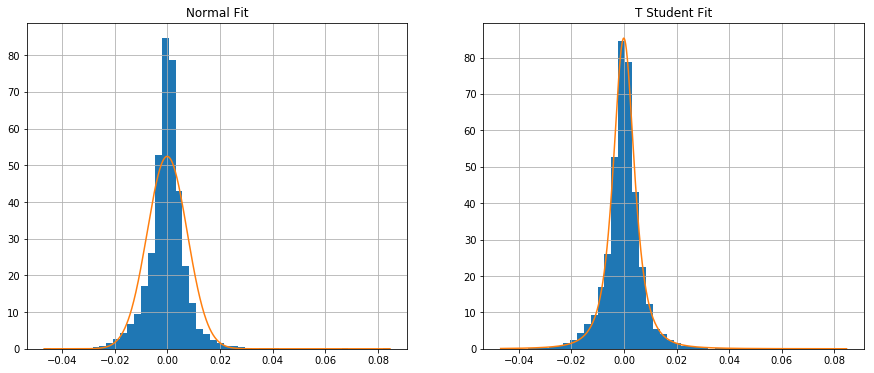

In [32]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

#normal fit
data.hist(bins=50, normed=True, ax=ax[0])
x =np.linspace(data.min(),data.max(),1000)
mu, std = norm.fit(data)
pdf = norm.pdf(x, mu, std)
ax[0].plot(x, pdf)
ax[0].set_title('Normal Fit')


#normal fit
from scipy.stats import t
data.hist(bins=50, normed=True, ax=ax[1])
x =np.linspace(data.min(),data.max(),1000)

# fit
parameters = t.fit(data)
pdf = t.pdf(x, *parameters)
ax[1].plot(x, pdf)
print(parameters)

ax[1].set_title('T Student Fit')

### comparison with generated sample

In [22]:
def generate_projected_sample(rets, N=1, sample_size=50000, distribution=t):
    np.random.seed(seed=123)    
    # MLE of the sample for a general distribution (to be improved) 
    dist_fit_params = distribution.fit(rets)

    projected_sample = np.zeros(sample_size)
    for k in range(N):
        projected_sample += distribution.rvs(*dist_fit_params, size=sample_size)

    return projected_sample

In [48]:
coin = 'LTC'
data = mkt.crypto_returns_data(coin, time_step='H', start_date=datetime.datetime(2018,1,26)).dropna()

In [49]:
### Create a dataframe with the different values for different fits

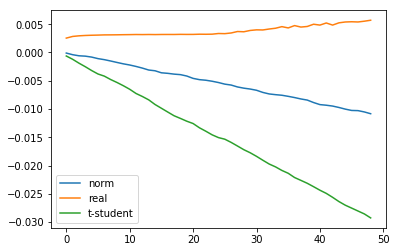

In [50]:
data_df = {'real':[], 'norm':[], 't-student':[]}
for k in range(1,50):
    data_df['real'].append(mkt.crypto_returns_data(coin, time_step=str(1*k)+'H').dropna().mean())
    data_df['norm'].append(generate_projected_sample(data, distribution=norm, N=k).mean())
    data_df['t-student'].append(generate_projected_sample(data, distribution=t, N=k).mean())

fitting_df = pd.DataFrame(data_df)
fitting_df.plot()

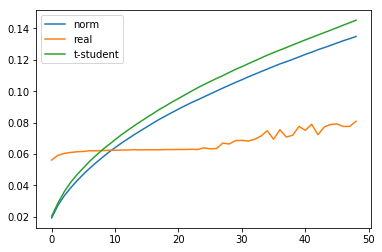

In [51]:
data_df = {'real':[], 'norm':[], 't-student':[]}
for k in range(1,50):
    data_df['real'].append(mkt.crypto_returns_data(coin, time_step=str(k*1)+'H').dropna().std())
    data_df['norm'].append(generate_projected_sample(data, distribution=norm, N=k).std())
    data_df['t-student'].append(generate_projected_sample(data, distribution=t, N=k).std())

fitting_df = pd.DataFrame(data_df)
fitting_df.plot()

# Analysis on the fitting parameters

Here we analyse how well the fitting is made between the normal and t-student accross the projections for N steps.

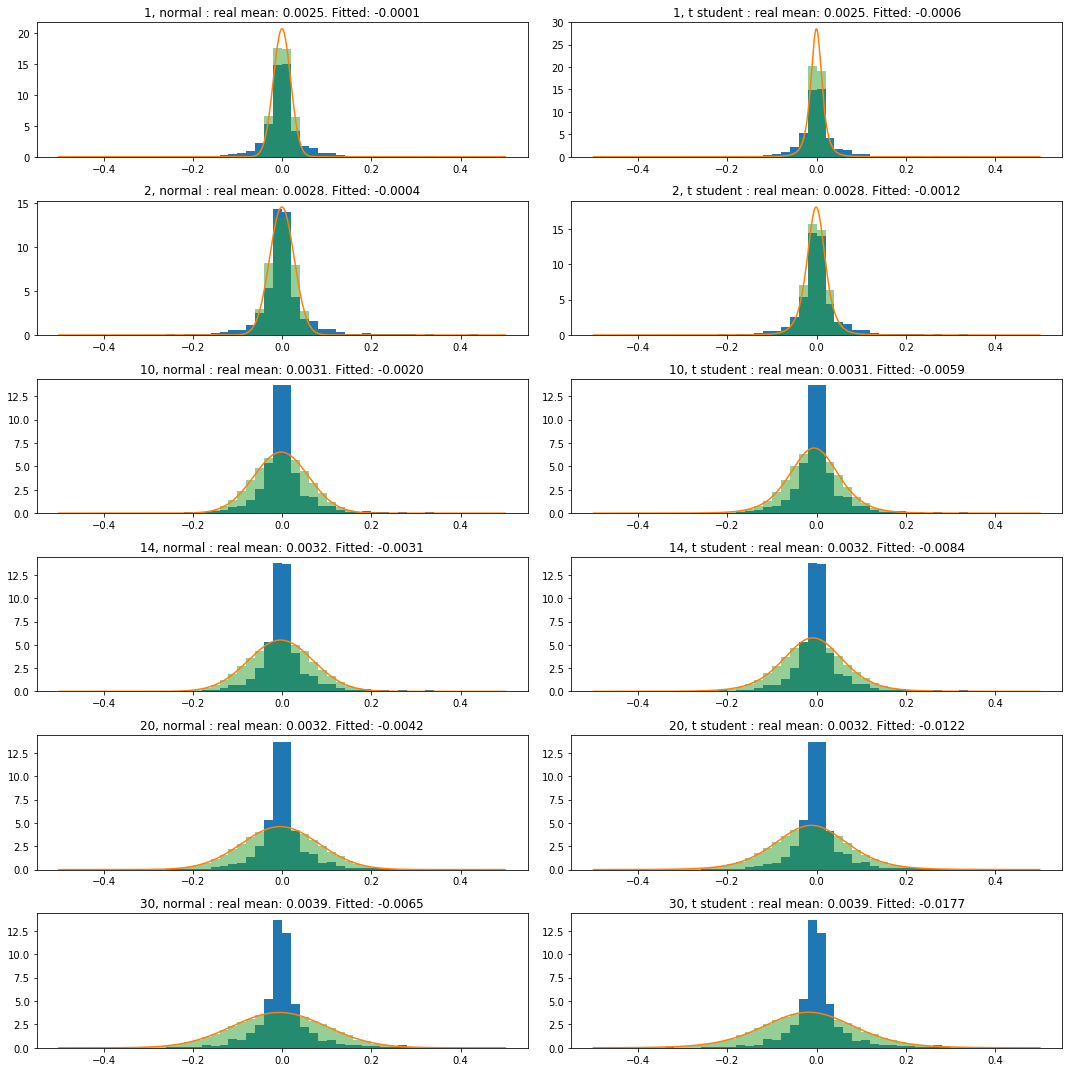

In [52]:
fig, ax = plt.subplots(6,2,figsize=(15,15))

for d, distribution in enumerate([norm, t]):
    title='normal'*(d==0)+'t student'*(d==1)
    for i, k in enumerate([1, 2, 10, 14, 20, 30]):
        # real data
        real = mkt.crypto_returns_data(coin, time_step=str(k*1)+'H').dropna()
        ax[i, d].hist(real, bins=50, normed=True, range=(-0.5, 0.5))
        
        #projections
        params = distribution.fit(real)
        proj_rets = generate_projected_sample(rets=data, N=k, distribution=distribution)
        params_proj = distribution.fit(proj_rets)
        x = np.linspace(-0.5, 0.5, 10000) 
        ax[i, d].plot(x, distribution.pdf(x, *params_proj))
        ax[i, d].hist(proj_rets, bins=50, normed=True, alpha=0.5, range=(-0.5, 0.5))
        ax[i, d].set_title('{}, {} : real mean: {}. Fitted: {}'.format(k, title, '%.4f'%(real.mean()), '%.4f'%(proj_rets.mean())))
    plt.tight_layout()